## Visualizing patch foraging task sessions

This notebook processes the outputs of `/code/scripts/train_treadmill_session` and creates visuals.

In [14]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy as copy
from tools.nb_analysis_tools import load_behavioral_data, parse_behavioral_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**List of all features loaded by `parse_behavioral_data`**

| Feature name                         | Type                  | Description          |
|------------------------------------|-----------------------------------|--------------------------------------|
| `agent_in_patch`                  | List of integers (0 or 1)         | Indicates if the agent is in a patch (1) or not (0) |
| `current_patch_start`             | List of integers                  | Start position of current patch     |
| `reward_bounds`                   | List of tuples (int, int)         | Start position and end position of current reward site  |
| `current_patch_num`               | List of integers                  | Identifier for the current patch    |
| `reward_site_idx`                 | List of integers                  | Index of current reward site within patch; -1 if not in patch  |
| `action`                          | List of integers                  | Actions taken by the agent          |
| `current_position`                | List of integers                  | Position of the agent over time     |
| `reward`                          | List of integers (0 or 1)         | Reward received by the agent       |
| `patch_reward_param`              | List of integers                  | Reward parameter of the current patch |
| `current_reward_site_attempted`   | List of integers                  | Binary encoding of whether the agent attempted reward at time step |
| `rewards_at_positions`                | List of integers        | Rewards observed at different positions             |
| `reward_attempted_at_positions`       | List of integers            | Reward attempts made at different positions         |
| `all_dwell_times`                     | List of integers           | Time spent within current reward site                     |
| `rewards_seen_in_patch`               | List of integers                  | Rewards encountered in the current patch           |


In [ ]:
def plot_sesson(data_path, env_idx, update_num=None, xlim=None, max_reward_param=30, max_reward_sites=8):

    b_data_raw = load_behavioral_data(data_path, update_num).__next__()
    b_data = parse_behavioral_data(b_data_raw, env_idx)

    # resulting loaded `b_data` is dictionary of features that contains values across time for an entire session
    # ex:
    # b_data = {
    #     'agent_in_patch' : [0, 1, 0, ...],
    #     'current_patch_start': [10, 10, 10, ..],
    #     'reward_bounds': [(0, 10), (0, 10) ... (20, 30)],
    #     'current_patch_num': [0, 0, 0, 0 ...],
    #     'action': [0, 0, 1, 1 ...],
    #     'current_position': [0, 1, 2, 2, 3 ...],
    #     'reward' [0, 0, 0, 1, 0, 1 ...],
    #     'patch_reward_param': [0, 30, 30, 30, 10, 10 ...],
    #     'current_reward_site_attempted': [0, 0, 1, 1 ...],
    # }

    rewards_at_positions = b_data['rewards_at_positions']
    reward_attempted_at_positions = b_data['reward_attempted_at_positions']
    all_patch_nums = b_data['current_patch_num']
    all_patch_reward_params = b_data['patch_reward_param']
    rewards_seen_in_patch = b_data['rewards_seen_in_patch']
              
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(10 * scale, 3 * scale))
    
    axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)
    axs.scatter(np.arange(len(rewards_at_positions))[rewards_at_positions > 0], rewards_at_positions[rewards_at_positions > 0] * 2, c='purple', marker='*')
    axs.scatter(np.arange(len(reward_attempted_at_positions))[reward_attempted_at_positions > 0], reward_attempted_at_positions[reward_attempted_at_positions > 0] * 2.5, c='purple', marker='s')
    
    reward_param_of_stop = []
    site_idx_of_stop =  []
    site_stops_for_patch_type = np.zeros((all_patch_nums.max() + 1, max_reward_sites))
    acc_reward_stops_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
    acc_reward_stop_opportunities_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
    patches_entered_for_patch_type = np.zeros((all_patch_nums.max() + 1,))
    reward_param_for_patch_type = np.zeros((all_patch_nums.max() + 1,))

    cmap = mpl.colormaps['winter']
    
    s_0 = 1.1
    s_1 = 1.75
    last_pstart = None
    pb = None
    last_reward_site_start = None
    reward_site_start = None
    patch_count = 0
    rw_site_counter = 0
    plotted_cnt = 0

    for i, pstart in enumerate(b_data['current_patch_start']):
        # print(f'Step {i}')
        if last_pstart is None or (pstart != last_pstart).any():
            patches_entered_for_patch_type[all_patch_nums[i]] += 1
            reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
            patch_count += 1
            pb = [pstart, pstart]
            c = cmap(all_patch_reward_params[i] / max_reward_param) if all_patch_reward_params[i] > 0 else 'black'
            rw_site_counter = 0
        
        rwsb = copy(b_data['reward_bounds'][i])
        reward_site_start = int(rwsb[0])
        # print('rwsite_start', reward_site_start)
        # print('last_rwsite_start', last_reward_site_start)
        if last_reward_site_start is None or not np.isclose(last_reward_site_start, reward_site_start):
            axs.fill_between(list(rwsb), s_0 * np.ones(2), y2=s_1 * np.ones(2), alpha=0.5, color=c, zorder=-1)
            axs.fill_between(list(rwsb), np.zeros(2), y2=s_0 * np.ones(2), alpha=0.2, color=c, zorder=-1)

            if rewards_seen_in_patch[i] < 40:
                acc_reward_stop_opportunities_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1
            
            if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                pb[1] = rwsb[1]
                axs.fill_between(pb, s_0 * np.ones(2), s_1 * np.ones(2), alpha=0.2, color=c, zorder=-2)
                axs.fill_between(pb, np.zeros(2), s_0 * np.ones(2), alpha=0.05, color=c, zorder=-2)
            else:
                reward_param_of_stop.append(b_data['patch_reward_param'][i])
                site_idx_of_stop.append(rw_site_counter)
                
                if rw_site_counter < max_reward_sites:
                    site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1

                if rewards_seen_in_patch[i] < 40:
                    acc_reward_stops_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1
                    
                rw_site_counter += 1
        
        last_pstart = pstart
        last_reward_site_start = reward_site_start

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])
    axs.set_ylim(0)
    axs.set_ylabel('Avg. running speed')
    axs.set_xlabel('Position')
    print('Patch count:', patch_count)
    
    scale = 1
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(site_stops_for_patch_type.shape[1])
    for k in range(site_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        axs[k].bar(x, site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k], color=c)
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Odor site number in patch')

    scale = 1
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(acc_reward_stops_for_patch_type.shape[1])
    for k in range(acc_reward_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)
        axs[k].set_ylim(0, 1.1)
    axs[0].set_xlim(-3, 43)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Total reward in patch')

C:\Users\david.bell\AppData\Local\Temp\ipykernel_29292\2305143757.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 544


C:\Users\david.bell\AppData\Local\Temp\ipykernel_29292\2305143757.py:103: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


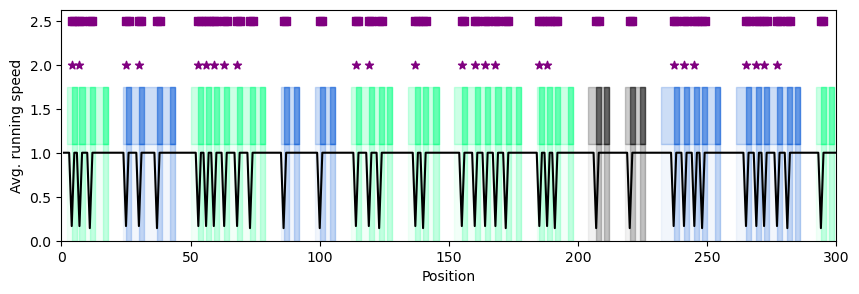

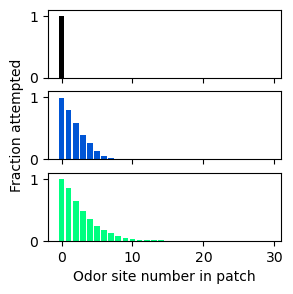

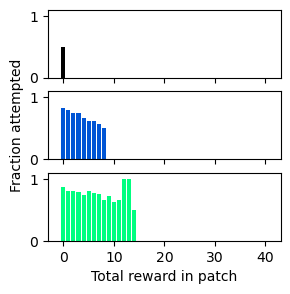

In [31]:
plot_sesson(
    '../../results/wsls_test_2025-03-07_11_01_56_334758/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

In [32]:
def plot_avg_stops_vs_reward_param(data_paths, update_num=None, max_reward_param=10, max_reward_sites=30, model_colors=None):

    cmap = mpl.colormaps['winter']
    if model_colors is None:
        model_colors = ['purple', 'green']

    scale = 1
    fig_sensitivity, axs_sensitivity = plt.subplots(6, 5, figsize=(8 * scale, 6 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        d = load_behavioral_data(data_path, update_num).__next__()
    
        for env_idx in range(30):
            b_data = parse_behavioral_data(d, env_idx)
            rewards_at_positions = b_data['rewards_at_positions']
            reward_attempted_at_positions = b_data['reward_attempted_at_positions']
            all_patch_nums = b_data['current_patch_num']
            all_patch_reward_params = b_data['patch_reward_param']
            
            reward_param_of_stop = []
            site_idx_of_stop =  []
            site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
            patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            
            last_pstart = None
            last_reward_site_start = None
            patch_count = 0
            for i, pstart in enumerate(b_data['current_patch_start']):
                if last_pstart is None or (pstart != last_pstart).any():
                    patches_entered_for_patch_type[all_patch_nums[i]] += 1
                    reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                    patch_count += 1
                    pb = [pstart, pstart]
                    rw_site_counter = 0
                
                rwsb = copy(b_data['reward_bounds'][i])
                reward_site_start = int(rwsb[0])

                if last_reward_site_start is None or last_reward_site_start != reward_site_start:
                    if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                        pb[1] = rwsb[1]
                    else:
                        reward_param_of_stop.append(b_data['patch_reward_param'][i])
                        site_idx_of_stop.append(rw_site_counter)
                        if rw_site_counter < max_reward_sites:
                            site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                        rw_site_counter += 1
        
                last_pstart = pstart
                last_reward_site_start = reward_site_start
    
            scale = 1
            fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
            # mx = site_stops_for_patch_type.max()
    
            avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
            
            x = np.arange(1, site_stops_for_patch_type.shape[1] + 1)
            for k in range(site_stops_for_patch_type.shape[0]):
                cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]
                c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
                axs[k].bar(x, cdf, color=c)
                axs[k].set_ylim(0, 1.1)
    
                pdf = cdf - np.concatenate([cdf[1:], np.zeros(1)])
                # axs[k].bar(x, pdf, color=cmap(reward_param_for_patch_type[k] / max_reward_param))
    
                avg_stops_for_patch_type[k] = np.dot(pdf, x)
    
            axs[1].set_ylabel('Fraction attempted')
            axs[2].set_xlabel('Odor site number in patch')
    
            ordering = np.argsort(reward_param_for_patch_type)
    
            axs_sensitivity[int(env_idx / 5), env_idx % 5].plot(reward_param_for_patch_type[ordering], avg_stops_for_patch_type[ordering], c=model_colors[idx_data_path])
            axs_sensitivity[int(env_idx / 5), env_idx % 5].scatter(reward_param_for_patch_type, avg_stops_for_patch_type, c=model_colors[idx_data_path])
        
    axs_sensitivity[0, 0].set_ylim(0)
    axs_sensitivity[0, 0].set_xlim(0, max_reward_param * 1.1)
    axs_sensitivity[1, 0].set_ylabel('Avg number of stops')
    axs_sensitivity[-1, 2].set_xlabel('Reward decay parameter')
            
    

C:\Users\david.bell\AppData\Local\Temp\ipykernel_29292\3599150559.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


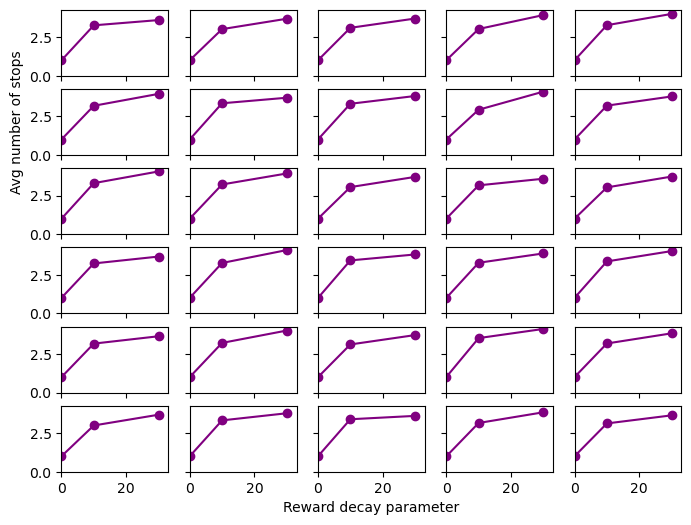

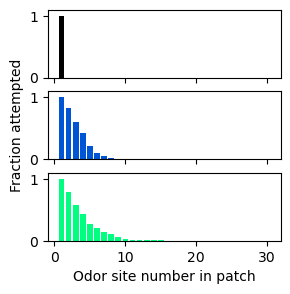

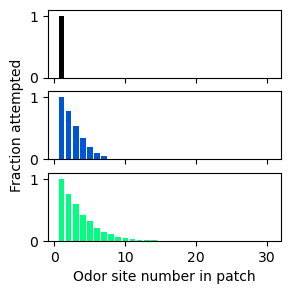

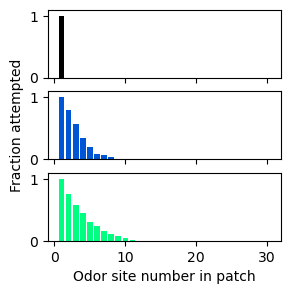

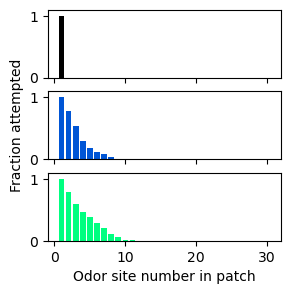

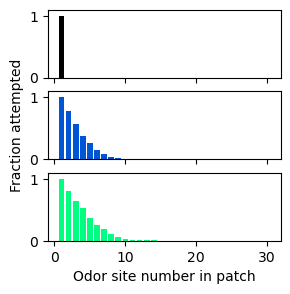

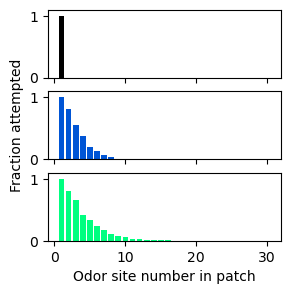

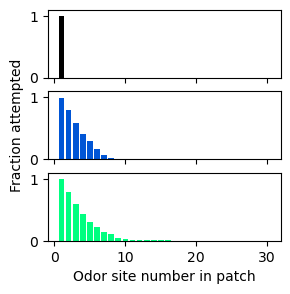

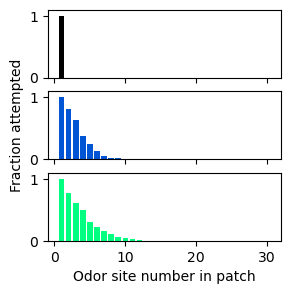

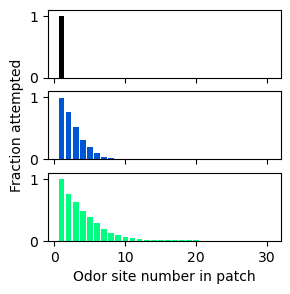

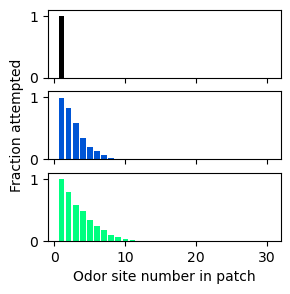

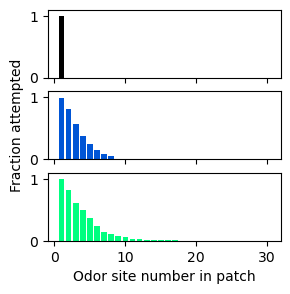

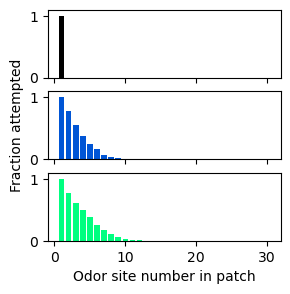

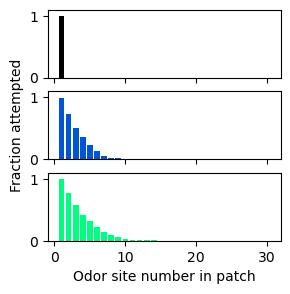

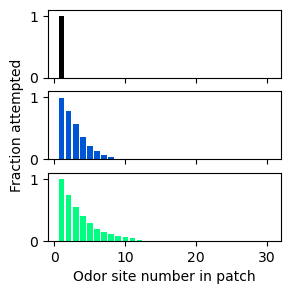

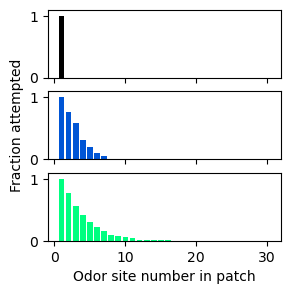

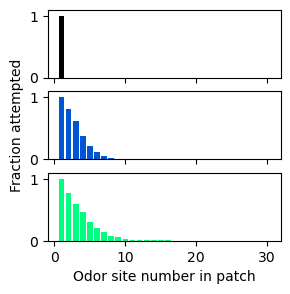

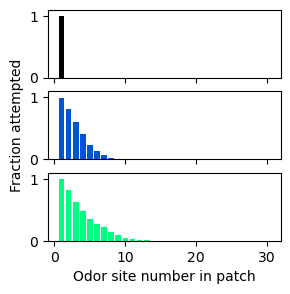

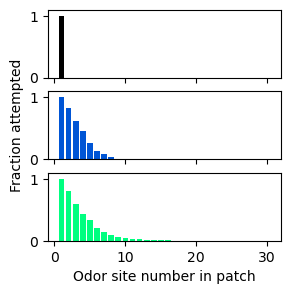

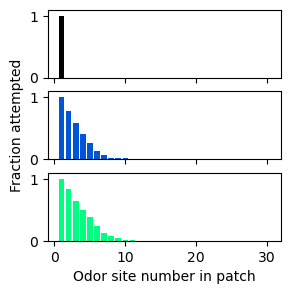

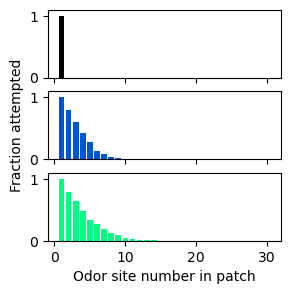

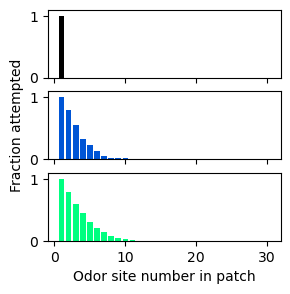

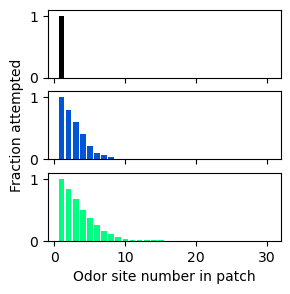

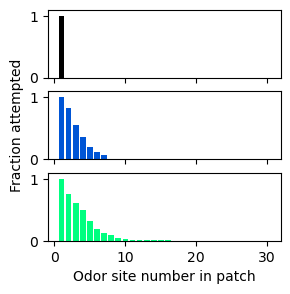

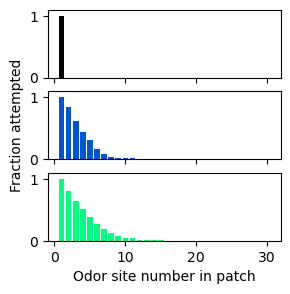

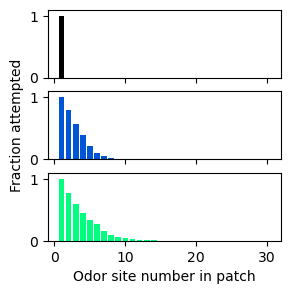

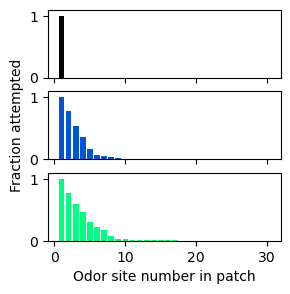

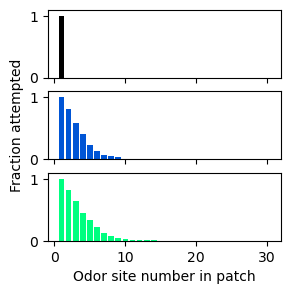

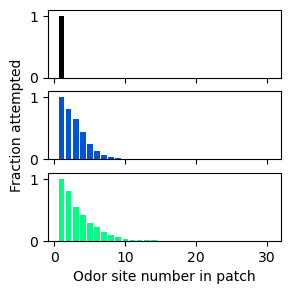

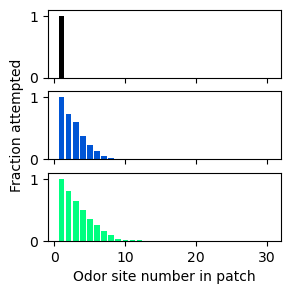

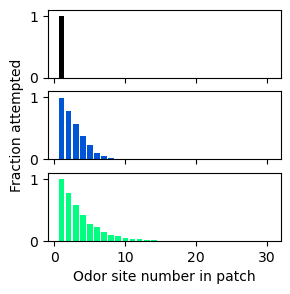

In [34]:
plot_avg_stops_vs_reward_param([
        '../../results/wsls_test_2025-03-07_11_01_56_334758/state',
    ],
    max_reward_param=30,
)